## 단순한 계층 구현하기

곱셈 계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y

        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다
        dy = dout * self.x
        
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax) ## 사실 이 부분을 `mul_apple_layer`로 구해도 전혀 상관이 없다는 거..

print(price)

220.00000000000003


In [3]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


덧셈 계층

In [4]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1 ## 위 forward의 식을 미분하면 자기 자신의 계수가 나오는데 여기서는 1임
        dy = dout * 1
        return dx, dy

In [5]:
# 변수 초기화
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 각 계층 생성
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 활성화 함수 계층 구현하기

ReLU

In [6]:
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy() ## 원본 arrary의 값이 변경되지 않을 수 있도록. 그래야 나중에 미분을 할 수 있음
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout ## 동일한 객체를 참조. 따라서 코드 가독성을 높이기 위한 작업으로 이해할 수 있음

        return dx

In [7]:
import numpy as np

x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

mask = (x <= 0)
print(mask) ## 따라서 array의 값 중에서 0 이하인 값들을 전부 0으로 바꿀 수 있게 됨

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


Sigmoid

In [8]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out ## forward의 출력을 self.out에 저장해두기

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out ## forward의 출력을 이용하여 backward 계산하기

        return dx

## Affine/Softmax 계층 구현하기

Affine 계층

In [9]:
X = np.random.rand(2)
W = np.random.rand(2, 3)
B = np.random.rand(3)

print(X.shape)
print(W.shape)
print(B.shape)

Y = np.dot(X, W) + B
print(Y)

(2,)
(2, 3)
(3,)
[0.90018938 1.18194954 0.39798179]


배치용 Affine 계층

In [10]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1,2,3])

print(X_dot_W)
print(X_dot_W + B) ## 편향은 배치 내 각 sample(data)에 공통적으로 더해진다

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


In [11]:
dY = np.array([[1,2,3], [4,5,6]])
print(dY)

dB = np.sum(dY, axis=0) ## axis=0 이어야 행 단위로 합 연산이 가능
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


In [12]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        ## 뺄셈이 가능하도록 원래 변수와의 차원을 맞춰서 미분 계수를 구해야 함
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout) ## 반환하지 않는 변수를 선언하는 이유는 무엇일까?
        self.db = np.sum(dout, axis=0)

        return dx

Softmax-with-Loss 계층

In [13]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))
    

In [14]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)

    if y.size == t.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [15]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

## 오차역전파법 구현하기

오차역전파법을 이용한 신경망 구현하기

In [16]:
from collections import OrderedDict

In [17]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1-fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()

    return grad

In [18]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size) ## 어차피 0이므로 초기화 가중치를 곱할 필요가 없음
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: ## 원핫 벡터인 경우 값 하나로 변경해주는 과정
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

오차역전파법으로 구한 기울기 검증하기

In [19]:
## 여기에 나타난 오차값은 실행 시마다 달라짐
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:4.2538532779391184e-10
b1:2.5331802150654837e-09
W2:6.208913918675607e-09
b2:1.3971694101388986e-07


오차역전파법을 사용한 학습 구현하기

In [27]:
from dataset.mnist import load_mnist
from tqdm.auto import tqdm
## 학습 시간이 무척 짧은 것을 알 수 있다.

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iter_nums = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in tqdm(range(iter_nums)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"{i}th iter - train accuracy: {train_acc:.3f}%, test_accuracy: {test_acc:.3f}%")

  0%|          | 0/20000 [00:00<?, ?it/s]

0th iter - train accuracy: 0.116%, test_accuracy: 0.115%
600th iter - train accuracy: 0.904%, test_accuracy: 0.905%
1200th iter - train accuracy: 0.922%, test_accuracy: 0.925%
1800th iter - train accuracy: 0.934%, test_accuracy: 0.934%
2400th iter - train accuracy: 0.943%, test_accuracy: 0.939%
3000th iter - train accuracy: 0.948%, test_accuracy: 0.946%
3600th iter - train accuracy: 0.955%, test_accuracy: 0.952%
4200th iter - train accuracy: 0.959%, test_accuracy: 0.956%
4800th iter - train accuracy: 0.963%, test_accuracy: 0.959%
5400th iter - train accuracy: 0.965%, test_accuracy: 0.959%
6000th iter - train accuracy: 0.969%, test_accuracy: 0.965%
6600th iter - train accuracy: 0.971%, test_accuracy: 0.965%
7200th iter - train accuracy: 0.973%, test_accuracy: 0.967%
7800th iter - train accuracy: 0.972%, test_accuracy: 0.964%
8400th iter - train accuracy: 0.976%, test_accuracy: 0.968%
9000th iter - train accuracy: 0.977%, test_accuracy: 0.968%
9600th iter - train accuracy: 0.978%, test_a

In [21]:
from dataset.mnist import load_mnist
from tqdm.auto import tqdm
## 학습 시간이 무척 짧은 것을 알 수 있다.

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=70, output_size=10)

iter_nums = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list_70 = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in tqdm(range(iter_nums)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list_70.append(test_acc)
        print(f"{i}th iter - train accuracy: {train_acc:.3f}%, test_accuracy: {test_acc:.3f}%")

  0%|          | 0/20000 [00:00<?, ?it/s]

0th iter - train accuracy: 0.116%, test_accuracy: 0.119%
600th iter - train accuracy: 0.906%, test_accuracy: 0.909%
1200th iter - train accuracy: 0.925%, test_accuracy: 0.927%
1800th iter - train accuracy: 0.939%, test_accuracy: 0.941%
2400th iter - train accuracy: 0.947%, test_accuracy: 0.947%
3000th iter - train accuracy: 0.951%, test_accuracy: 0.948%
3600th iter - train accuracy: 0.959%, test_accuracy: 0.956%
4200th iter - train accuracy: 0.963%, test_accuracy: 0.959%
4800th iter - train accuracy: 0.966%, test_accuracy: 0.963%
5400th iter - train accuracy: 0.970%, test_accuracy: 0.964%
6000th iter - train accuracy: 0.972%, test_accuracy: 0.967%
6600th iter - train accuracy: 0.974%, test_accuracy: 0.967%
7200th iter - train accuracy: 0.977%, test_accuracy: 0.969%
7800th iter - train accuracy: 0.977%, test_accuracy: 0.967%
8400th iter - train accuracy: 0.980%, test_accuracy: 0.970%
9000th iter - train accuracy: 0.981%, test_accuracy: 0.972%
9600th iter - train accuracy: 0.982%, test_a

In [22]:
from dataset.mnist import load_mnist
from tqdm.auto import tqdm
## 학습 시간이 무척 짧은 것을 알 수 있다.

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

iter_nums = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list_100 = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in tqdm(range(iter_nums)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list_100.append(test_acc)
        print(f"{i}th iter - train accuracy: {train_acc:.3f}%, test_accuracy: {test_acc:.3f}%")

  0%|          | 0/20000 [00:00<?, ?it/s]

0th iter - train accuracy: 0.103%, test_accuracy: 0.106%
600th iter - train accuracy: 0.903%, test_accuracy: 0.905%
1200th iter - train accuracy: 0.926%, test_accuracy: 0.927%
1800th iter - train accuracy: 0.939%, test_accuracy: 0.938%
2400th iter - train accuracy: 0.949%, test_accuracy: 0.947%
3000th iter - train accuracy: 0.955%, test_accuracy: 0.952%
3600th iter - train accuracy: 0.959%, test_accuracy: 0.956%
4200th iter - train accuracy: 0.965%, test_accuracy: 0.957%
4800th iter - train accuracy: 0.968%, test_accuracy: 0.963%
5400th iter - train accuracy: 0.971%, test_accuracy: 0.964%
6000th iter - train accuracy: 0.971%, test_accuracy: 0.964%
6600th iter - train accuracy: 0.976%, test_accuracy: 0.967%
7200th iter - train accuracy: 0.977%, test_accuracy: 0.969%
7800th iter - train accuracy: 0.978%, test_accuracy: 0.970%
8400th iter - train accuracy: 0.981%, test_accuracy: 0.971%
9000th iter - train accuracy: 0.980%, test_accuracy: 0.969%
9600th iter - train accuracy: 0.983%, test_a

In [24]:
print(f"x_train: {len(x_train)}")
print(f"t_train: {len(t_train)}")
print(f"x_test: {len(x_test)}")
print(f"t_test: {len(t_test)}")

x_train: 60000
t_train: 60000
x_test: 10000
t_test: 10000


/var/folders/hn/nrs0d2b91f1f7jdk9wdd8yfc0000gn/T/ipykernel_1140/2770030002.py:15: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax2.set_ylim(0.965, 0.979, 0.001)


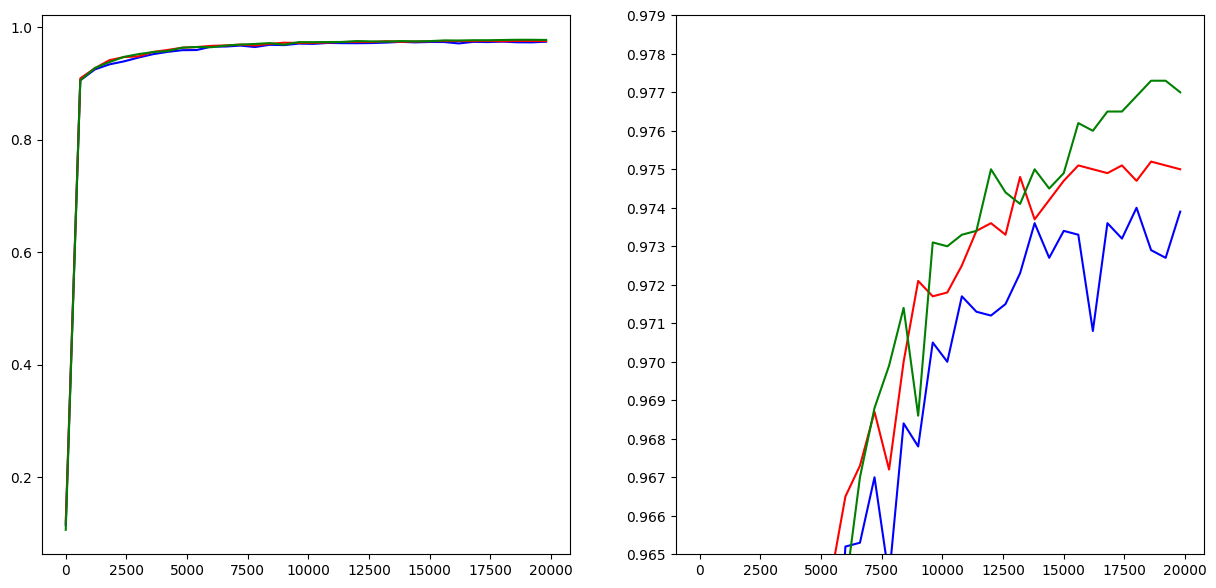

In [30]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(15)

ax1.plot(np.arange(0, 20000, 600), test_acc_list, color='blue')
ax1.plot(np.arange(0, 20000, 600), test_acc_list_70, color='red')
ax1.plot(np.arange(0, 20000, 600), test_acc_list_100, color='green')

ax2.plot(np.arange(0, 20000, 600), test_acc_list, color='blue')
ax2.plot(np.arange(0, 20000, 600), test_acc_list_70, color='red')
ax2.plot(np.arange(0, 20000, 600), test_acc_list_100, color='green')
ax2.set_ylim(0.965, 0.979, 0.001)
ax2.set_yticks(np.arange(0.965, 0.979, 0.001))


plt.show()

In [76]:
from dataset.mnist import load_mnist
from tqdm.auto import tqdm
## 학습 시간이 무척 짧은 것을 알 수 있다.

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iter_nums = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in tqdm(range(iter_nums)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"{i}th iter - train accuracy: {train_acc:.3f}%, test_accuracy: {test_acc:.3f}%")

  0%|          | 0/10000 [00:00<?, ?it/s]

0th iter - train accuracy: 0.071%, test_accuracy: 0.073%
600th iter - train accuracy: 0.905%, test_accuracy: 0.907%
1200th iter - train accuracy: 0.922%, test_accuracy: 0.924%
1800th iter - train accuracy: 0.937%, test_accuracy: 0.938%
2400th iter - train accuracy: 0.946%, test_accuracy: 0.944%
3000th iter - train accuracy: 0.952%, test_accuracy: 0.951%
3600th iter - train accuracy: 0.957%, test_accuracy: 0.954%
4200th iter - train accuracy: 0.962%, test_accuracy: 0.958%
4800th iter - train accuracy: 0.964%, test_accuracy: 0.962%
5400th iter - train accuracy: 0.969%, test_accuracy: 0.964%
6000th iter - train accuracy: 0.971%, test_accuracy: 0.964%
6600th iter - train accuracy: 0.974%, test_accuracy: 0.967%
7200th iter - train accuracy: 0.975%, test_accuracy: 0.967%
7800th iter - train accuracy: 0.975%, test_accuracy: 0.970%
8400th iter - train accuracy: 0.978%, test_accuracy: 0.970%
9000th iter - train accuracy: 0.977%, test_accuracy: 0.969%
9600th iter - train accuracy: 0.980%, test_a

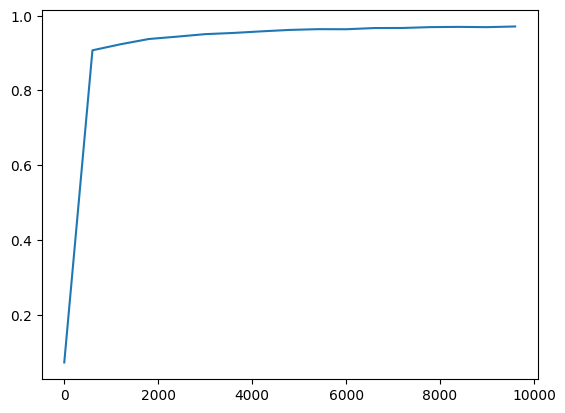

In [82]:
plt.plot(np.arange(0, 10000, 600), test_acc_list)
plt.show()

/var/folders/hn/nrs0d2b91f1f7jdk9wdd8yfc0000gn/T/ipykernel_18851/3066349409.py:2: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0.9,1.0,0.005)


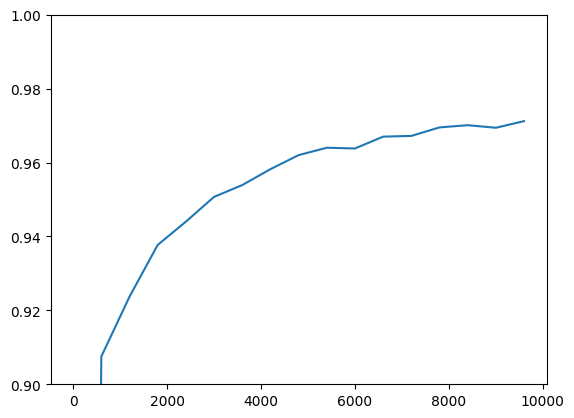

In [86]:
plt.plot(np.arange(0, 10000, 600), test_acc_list)
plt.ylim(0.9,1.0,0.005)
plt.show()